# Analysis for locator

## Performance Plots for the three functions

In [1]:
import pandas as pd
import numpy as np
import time
import os
from haversine import haversine
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from deepimpact import GeospatialLocator
from deepimpact import great_circle_distance

### 1. Performance of `great_circle_distance`

In [29]:
# Generate random latitudes and longitudes pairs of size m
def generate_random_latlon(m):
    
    latitudes = np.random.uniform(-90, 90, m)
    longitudes = np.random.uniform(-180, 180, m)
    latlon = np.column_stack((latitudes, longitudes))
    
    return latlon

In [30]:
# timing our function and compare it with haversine
sizes = [1,5,10,100,500,800,1000,2000,3000,5000,10000]
great_circle_times = []
haversine_times = []
for size in sizes:
    
    latlon1 = generate_random_latlon(size)
    latlon2 = generate_random_latlon(size)

    start_time = time.time()
    great_circle_distance(latlon1,latlon2)
    end_time = time.time()
    great_circle_times.append(end_time - start_time)
    
    start_time = time.time()
    for coord1, coord2 in zip(latlon1, latlon2):
        haversine(coord1, coord2)*1000
    end_time = time.time()
    haversine_times.append(end_time - start_time)



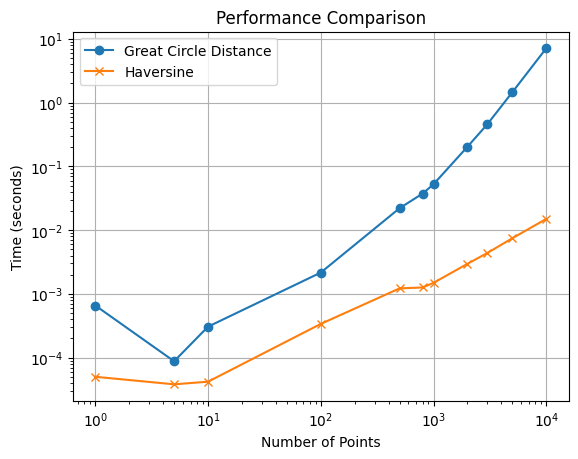

In [37]:
#  plotting
plt.plot(sizes, great_circle_times, label='Great Circle Distance', marker='o')
plt.plot(sizes, haversine_times, label='Haversine', marker='x')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Points')
plt.ylabel('Time (seconds)')
plt.title('Performance Comparison')
plt.legend()
plt.grid(True)
plt.show()

The **great_circle_distance function**  employs vectorized methods to improve the  performance. We observe this performance by comparing the timing of great_circle_distance and **haversine**. For small datasets (less than 1000 point pairs), the performance difference between the two functions is minimal. However, as the size of the dataset increases, the growth rate of great_circle_distance is exponential and outpaces that of haversine, indicating a higher time complexity. But for the size of data points in the damage impact part, the performance of great_circle_distance is entirely satisfactory.

### Performance of `get_postcodes_by_radius`

In [22]:
# Function to generate test data and save it to a CSV file
def generate_test_data_and_save(num_points):
    X = np.random.rand(num_points, 3) * 100  # Random lat-lon pairs
    df = pd.DataFrame(X, columns=['Postcode','Latitude', 'Longitude'])
    file_path = f'test_data_{num_points}.csv'
    df.to_csv(file_path, index=False)
    return df, file_path


In [23]:
# Test different sizes and radius
sizes = [1e2,1e3,1e4,1e5,1e6,1e7,1e8]
radii_values = [1e2, 5e2, 1e3, 5e3,1e4,5e4,1e5,5e5,1e6,5e6,1e7]  # (num_points, num_radii)
results = []

for num_pts in sizes:
    df, file_path = generate_test_data_and_save(int(num_pts))
    print(df.shape)
    for raddi in radii_values:
        test_location = (51.4981, -0.1773)
        test_radii = [raddi]
        locator = GeospatialLocator(file_path)
        start_time = time.time()
        postcodes = locator.get_postcodes_by_radius(test_location, test_radii)
        end_time = time.time()
        total_time = end_time - start_time
        results.append((num_pts, raddi, total_time))
        results_array = np.array(results)
    # Optionally delete the file after use
    os.remove(file_path)      

    




(100, 3)
(1000, 3)
(10000, 3)
(100000, 3)
(1000000, 3)
(10000000, 3)
(100000000, 3)


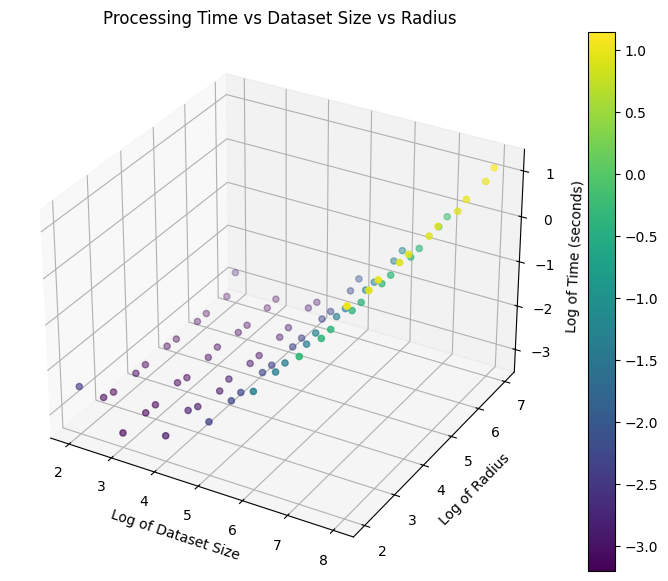

In [24]:
# log transformation
log_sizes = np.log10(results_array[:, 0])
log_radii = np.log10(results_array[:, 1])
log_times = np.log10(results_array[:, 2])

# 3d plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(log_sizes,log_radii, log_times, c=log_times, cmap='viridis')

# add colour
plt.colorbar(sc)
ax.set_xlabel('Log of Dataset Size')
ax.set_ylabel('Log of Radius')
ax.set_zlabel('Log of Time (seconds)')
ax.set_title('Processing Time vs Dataset Size vs Radius')

plt.show()

In our performance tests for the **get_postcodes_by_radius**, we varied the size of the geospatial dataset and the radius. The 3D plot allows us to see the impact of these two parameters on the function's performance, where lighter color indicates longer execution time. From the graph above, it is evident that along the x-axis, the color change is more pronounced, suggesting that the size of the dataset has a greater effect on the function's performance. Our geo dataset contains about 1.7 million rows, which is approximately on the order of 1e6, and from the chart and we can anticipate that the execution times are between 1e-3 and 1e-2 seconds.

### Performance of `get_population_by_radius`

In [25]:
 # Function to generate test data and save it to a CSV file
def generate_test_data_and_save(num_points):
    X = np.random.rand(num_points, 2) * 100 
    df = pd.DataFrame(X, columns=['Latitude', 'Longitude'])
    y = np.random.rand(num_points, 1) * 100
    df_population = pd.DataFrame(y, columns=['Population'])
    file_path1 = f'test_data_{num_points}.csv'
    file_path2 = f'test_data_population_{num_points}.csv'
    df.to_csv(file_path1, index=False)
    df_population.to_csv(file_path2, index=False)
    return df, file_path1,df_population,file_path2



    

In [57]:
# Test different sizes and radius
sizes = [1e2,1e3,1e4,1e5,1e6,1e7,1e8]
radii_values = [1e2, 5e2, 1e3, 5e3,1e4,5e4,1e5,5e5,1e6,5e6,1e7]  
results = []

for num_pts in sizes:
    df1, file_path1,df2,file_path2 = generate_test_data_and_save(int(num_pts))
    print(df1.shape)
    for raddi in radii_values:
        test_location = (51.4981, -0.1773)
        test_radii = [raddi]
        locator = GeospatialLocator()
        population_df = pd.DataFrame(df1, y)
        start_time = time.time()
        postcodes = locator.get_population_by_radius(test_location, test_radii)
        end_time = time.time()
        total_time = end_time - start_time
        results.append((num_pts, raddi, total_time))
        results_array = np.array(results)
    # Optionally delete the file after use
    os.remove(file_path1)
    os.remove(file_path2)     


(100, 2)
7412.0
my time:  0.022405147552490234
my time:  0.022886991500854492
my time:  0.022478818893432617
my time:  0.03118729591369629
my time:  0.0550079345703125
my time:  0.8381497859954834
my time:  3.289116859436035
my time:  38.71634793281555
my time:  77.71269297599792
my time:  83.51694893836975
my time:  83.25295209884644
(1000, 2)
7412.0
my time:  0.0231630802154541
my time:  0.02275824546813965
my time:  0.0227510929107666
my time:  0.030990123748779297
my time:  0.05542492866516113
my time:  0.8460700511932373
my time:  3.369967222213745
my time:  39.121116161346436
my time:  78.4035382270813
my time:  83.7452301979065
my time:  83.5407989025116
(10000, 2)
7412.0
my time:  0.023239850997924805
my time:  0.02304697036743164
my time:  0.025387048721313477
my time:  0.03245401382446289
my time:  0.057229042053222656
my time:  0.8488731384277344
my time:  3.318033218383789
my time:  38.816303968429565
my time:  78.21412897109985
my time:  83.32189393043518
my time:  83.8208

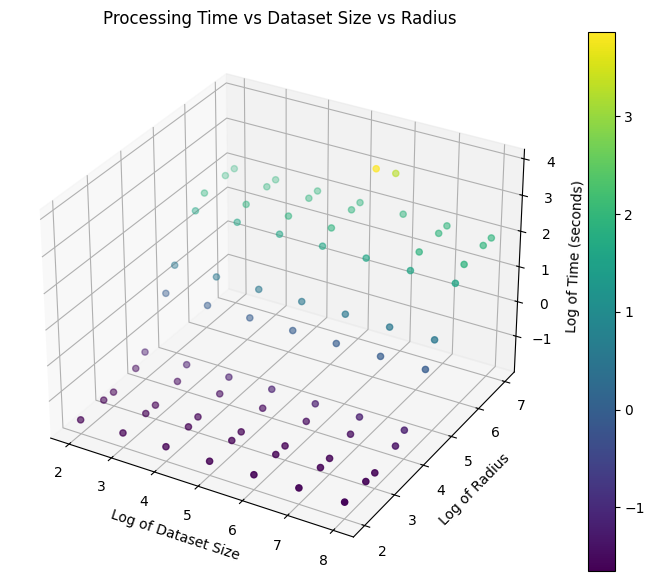

In [58]:
# plotting
# log transformation
log_sizes = np.log10(results_array[:, 0])
log_radii = np.log10(results_array[:, 1])
log_times = np.log10(results_array[:, 2])

# 3d plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(log_sizes,log_radii, log_times, c=log_times, cmap='viridis')

# add colour
plt.colorbar(sc)
ax.set_xlabel('Log of Dataset Size')
ax.set_ylabel('Log of Radius')
ax.set_zlabel('Log of Time (seconds)')
ax.set_title('Processing Time vs Dataset Size vs Radius')

plt.show()

In performance testing of the **get_population_by_radius** function, the runtime is assessed by varying the size of the dataset and the radius. The 3D graph illustrates that as the radius and dataset size increase, the runtime also increases, with a more rapid escalation in response to changes in the radius.

In [2]:
def get_population_by_radius_optimized2(self, X, radii):
            """
            Return the population within specific distances of input location.

            Parameters
            ----------
            X : arraylike
                Latitude-longitude pair of centre location
            radii : arraylike
                array of radial distances from X

            Returns
            -------
            list
                Contains the population closer than the elements of radii to
                the location X. Output should be the same shape as the radii array.

            Examples
            --------
            >>> locator = GeospatialLocator()
            >>> locator.get_population_by_radius_optimized((51.4981, -0.1773),\
                [1e2, 5e2, 1e3])
            [232, 7412, 27794]
            """
            population_list = []

            for radius in radii:
                # Calculate the distance from the input location to each grid cell
                self.population_df["Distance"] = self.norm(
                    self.population_df[["Latitude", "Longitude"]].values, X
                )
                nearest_grids = self.population_df[
                    self.population_df["Distance"] <= radius
                ]

                if nearest_grids.empty:
                    extended_radius = radius + self.grid_size/np.sqrt(2)
                    within_extended_radius = self.population_df[
                    self.population_df["Distance"] <= extended_radius
                    ]
                    extended_population = within_extended_radius["Population"].sum()
                
                    # Scale the population estimate back to the original area
                    scale_factor = (radius ** 2) / (extended_radius ** 2)
                    # Estimate population based on extended radius
                    total_population = population = int(extended_population * scale_factor)
                    
                
                else:
                    total_population = nearest_grids["Population"].sum()
                population_list.append(int(total_population))

            return population_list

[312, 7412, 27794]


## Improvements by using KD-tree

As the postcodes and population datasets are very large, we might improve the searching algorithm to accelarate the process of searching the postcodes and population within a given distance of a point. For our project, we try to use `KD-tree`. The code of searching using `KD-tree` is as follows.

In [1]:
class Node:
    def __init__(self, point, left=None, right=None):
        self.point = point
        self.left = left
        self.right = right

def build_kdtree(points, depth=0):
    if not points:
        return None

    k = 2  # number of dimensions
    axis = depth % k

    points.sort(key=lambda x: x[axis])
    median = len(points) // 2

    return Node(
        point=points[median],
        left=build_kdtree(points[:median], depth + 1),
        right=build_kdtree(points[median + 1:], depth + 1)
    )

def query_radius(node, target, radius, depth=0, results=None):
    if node is None:
        return

    if results is None:
        results = []

    # Ensure target and node.point are in the correct format
    target_array = np.array(target).reshape(1, -1)
    node_point_array = np.array(node.point).reshape(1, -1)

    # if great_circle_distance(node.point, target) < radius:
    #     results.append(node.point)

    if great_circle_distance(node_point_array, target_array) < radius:
        results.append(node.point)

    axis = depth % 2
    next_branch = None
    opposite_branch = None

    if target[axis] < node.point[axis]:
        next_branch = node.left
        opposite_branch = node.right
    else:
        next_branch = node.right
        opposite_branch = node.left

    query_radius(next_branch, target, radius, depth + 1, results)

    if abs(target[axis] - node.point[axis]) < radius:
        query_radius(opposite_branch, target, radius, depth + 1, results)

    return results

In [2]:
import os
import numpy as np
import pandas as pd
from scipy.spatial import KDTree
from deepimpact.locator import great_circle_distance

class GeospatialLocator_kdtree(object):
    def __init__(self,
                 postcode_file=os.sep.join(
                     (os.getcwd(), '..', 'resources', 'full_postcodes.csv')
                     ),
                 census_file=os.sep.join(
                     (os.getcwd(), '..', 'resources', 'UK_residential_population_2011_latlon.asc')
                     ),
                 norm=great_circle_distance):

        self.norm = norm
        self.postcodes = pd.read_csv(postcode_file)

        postcode_points = list(zip(self.postcodes['Latitude'], self.postcodes['Longitude']))
        self.postcode_tree = build_kdtree(postcode_points)
        self.postcode_tree_sci = KDTree(self.postcodes[['Latitude', 'Longitude']].values)

    def get_postcodes_by_radius(self, X, radii):
        postcodes_list = []

        for radius in radii:
            points_within_radius = query_radius(self.postcode_tree, X, radius)
            postcodes_within_radius = self.postcodes[
                self.postcodes[['Latitude', 'Longitude']].apply(tuple, axis=1).isin(points_within_radius)
            ]['Postcode'].tolist()
            postcodes_list.append(postcodes_within_radius)

        return postcodes_list
    
    def get_postcodes_by_radius_(self, X, radii):
        # Create empty list to store postcodes
        postcodes_list = []

        # Calculate the distance from the input location to each postcode
        self.postcodes['Distance'] = self.norm(self.postcodes[['Latitude', 'Longitude']].values, X)

        # Loop over the radii and append the postcodes within each radius
        for radius in radii:
            postcodes_list.append(self.postcodes[self.postcodes['Distance'] < radius]['Postcode'].values.tolist())

        return postcodes_list
    
    def get_postcodes_by_radius__(self, X, radii):
        postcodes_list = []
        for radius in radii:
            # Query the KD-tree instance
            indices = self.postcode_tree_sci.query_ball_point(X, radius)
            postcodes_list.append(self.postcodes.iloc[indices]['Postcode'].values.tolist())

        return postcodes_list
    
    def get_postcodes_by_radius___(self, X, radii):
        postcodes_list = []

        for radius in radii:
            # Convert radius from meters to degrees (approximation)
            radius_deg_lat = radius / 111000  # Approximately 111 km per degree of latitude
            radius_deg_lon = radius / (111000 * np.cos(np.radians(X[0])))  # Adjust for longitude at given latitude

            # Calculate approximate bounds for latitude and longitude
            lat_min, lat_max = X[0] - radius_deg_lat, X[0] + radius_deg_lat
            lon_min, lon_max = X[1] - radius_deg_lon, X[1] + radius_deg_lon

            # Preliminary filtering step using the grid approach
            filtered_postcodes = self.postcodes[(self.postcodes['Latitude'].between(lat_min, lat_max)) &
                                                (self.postcodes['Longitude'].between(lon_min, lon_max))]

            # Calculate the distance for the filtered postcodes
            filtered_postcodes['Distance'] = self.norm(filtered_postcodes[['Latitude', 'Longitude']].values, X)

            # Append the postcodes within the radius after the accurate distance calculation
            postcodes_list.append(filtered_postcodes[filtered_postcodes['Distance'] < radius]['Postcode'].values.tolist())

        return postcodes_list

In [ ]:
%%timeit
loc = GeospatialLocator_kdtree()
postcode_result = loc.get_postcodes_by_radius((51.4981, -0.1773), [1.5e3, 4.0e3])
print(postcode_result)

In [6]:
%%timeit
loc = GeospatialLocator_kdtree()
postcode_result = loc.get_postcodes_by_radius_((51.4981, -0.1773), [1.5e3, 4.0e3])
print(postcode_result)

[['SW100AD', 'SW100AE', 'SW100AG', 'SW100AH', 'SW100AJ', 'SW100AL', 'SW100AN', 'SW100AP', 'SW100AQ', 'SW100AR', 'SW100AS', 'SW100AU', 'SW100AW', 'SW100AX', 'SW100BG', 'SW100BQ', 'SW109AJ', 'SW109AL', 'SW109AN', 'SW109AP', 'SW109BN', 'SW109BP', 'SW109BS', 'SW109BT', 'SW109BW', 'SW109DS', 'SW109DZ', 'SW109EA', 'SW109FW', 'SW109HD', 'SW109HE', 'SW109HF', 'SW109HH', 'SW109HL', 'SW109HP', 'SW109HQ', 'SW109HR', 'SW109HT', 'SW109HU', 'SW109HW', 'SW109HX', 'SW109HY', 'SW109HZ', 'SW109JA', 'SW109JB', 'SW109JE', 'SW109JG', 'SW109JH', 'SW109JJ', 'SW109JP', 'SW109JQ', 'SW109JR', 'SW109JT', 'SW109JU', 'SW109JX', 'SW109JY', 'SW109JZ', 'SW109LA', 'SW109LB', 'SW109LE', 'SW109LF', 'SW109LG', 'SW109LH', 'SW109LJ', 'SW109LL', 'SW109LN', 'SW109LP', 'SW109LQ', 'SW109LR', 'SW109LS', 'SW109LW', 'SW109NB', 'SW109NE', 'SW109NF', 'SW109NJ', 'SW109NL', 'SW109NN', 'SW109NP', 'SW109NQ', 'SW109NR', 'SW109NW', 'SW109NY', 'SW109NZ', 'SW109PA', 'SW109PB', 'SW109PD', 'SW109PE', 'SW109PF', 'SW109PJ', 'SW109PN', 'SW109PR

In [ ]:
%%timeit
loc = GeospatialLocator_kdtree()
postcode_result = loc.get_postcodes_by_radius__((51.4981, -0.1773), [1.5e3, 4.0e3])
print(postcode_result)

In [ ]:
%%timeit
loc = GeospatialLocator_kdtree()
postcode_result = loc.get_postcodes_by_radius___((51.4981, -0.1773), [1.5e3, 4.0e3])
print(postcode_result)

In [3]:
from deepimpact.locator import GeospatialLocator

In [5]:
%%timeit
loc = GeospatialLocator()
postcode_result = loc.get_postcodes_by_radius((51.4981, -0.1773), [1.5e3, 4.0e3])
print(postcode_result)

[['SW100AD', 'SW100AE', 'SW100AG', 'SW100AH', 'SW100AJ', 'SW100AL', 'SW100AN', 'SW100AP', 'SW100AQ', 'SW100AR', 'SW100AS', 'SW100AU', 'SW100AW', 'SW100AX', 'SW100BG', 'SW100BQ', 'SW109AJ', 'SW109AL', 'SW109AN', 'SW109AP', 'SW109BN', 'SW109BP', 'SW109BS', 'SW109BT', 'SW109BW', 'SW109DS', 'SW109DZ', 'SW109EA', 'SW109FW', 'SW109HD', 'SW109HE', 'SW109HF', 'SW109HH', 'SW109HL', 'SW109HP', 'SW109HQ', 'SW109HR', 'SW109HT', 'SW109HU', 'SW109HW', 'SW109HX', 'SW109HY', 'SW109HZ', 'SW109JA', 'SW109JB', 'SW109JE', 'SW109JG', 'SW109JH', 'SW109JJ', 'SW109JP', 'SW109JQ', 'SW109JR', 'SW109JT', 'SW109JU', 'SW109JX', 'SW109JY', 'SW109JZ', 'SW109LA', 'SW109LB', 'SW109LE', 'SW109LF', 'SW109LG', 'SW109LH', 'SW109LJ', 'SW109LL', 'SW109LN', 'SW109LP', 'SW109LQ', 'SW109LR', 'SW109LS', 'SW109LW', 'SW109NB', 'SW109NE', 'SW109NF', 'SW109NJ', 'SW109NL', 'SW109NN', 'SW109NP', 'SW109NQ', 'SW109NR', 'SW109NW', 'SW109NY', 'SW109NZ', 'SW109PA', 'SW109PB', 'SW109PD', 'SW109PE', 'SW109PF', 'SW109PJ', 'SW109PN', 'SW109PR

It can be obtained from the results above that the operation based on `DataFrame` is faster than the `KD-tree` algorithm. Therefore we will still apply the `DataFrame` operation.